## Upload and config the image

In [24]:
# For uploading files
from google.colab import files
uploaded = files.upload()

Saving anh.jpg to anh.jpg


In [44]:
# Config the image path here
IMAGE_FILE = "hn.jpg"

## Visualize the image

In [45]:
import matplotlib.pyplot as plt

def show_image(image, title=None):
  if isinstance(image, str):
    image = plt.imread(image)

  fig, ax = plt.subplots()
  ax.imshow(image)
  ax.axis('off')

  plt.title(title, fontweight ="bold")
  plt.show()

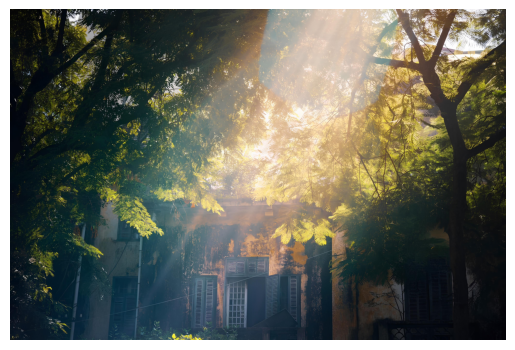

In [46]:
show_image(IMAGE_FILE)

## Grayscale CPU implementation

In [47]:
import numpy as np
import time

def grayscale_cpu(image_file):
  img = plt.imread(image_file)
  out = np.zeros(img.shape, np.uint8)
  start_t = time.time()
  print(f"Do grayscale image by cpu ...")

  for row_idx, row in enumerate(img):
    for col_idx, cell in enumerate(row):
      out[row_idx][col_idx] = [int(np.mean(cell))]*3

  total_time = time.time() - start_t
  print(f"It took {total_time} s to finish.")
  return out, total_time

grayscale_img, _ = grayscale_cpu(IMAGE_FILE)

Do grayscale image by cpu ...
It took 86.23371887207031 s to finish.


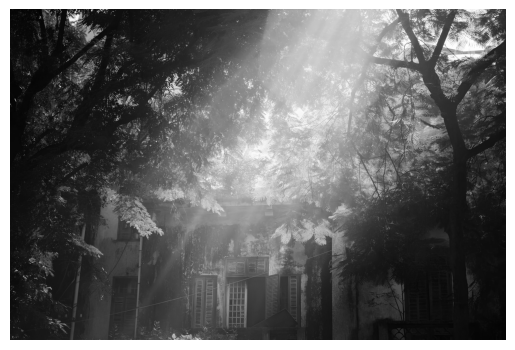

In [48]:
show_image(grayscale_img)

## Grayscale GPU implementation

In [61]:
from numba import cuda
import numpy as np
import time

@cuda.jit
def grayscale(src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  g = np.uint8((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3)
  dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g

def grayscale_gpu(image_file, blockSize=64):
  img = plt.imread(image_file)
  imageHeight, imageWidth, _ = img.shape
  pixelCount = imageWidth * imageHeight
  gridSize = int(pixelCount / blockSize)
  flatSrc = np.reshape(img, (pixelCount, 3))

  print(f"Do grayscale image by gpu, blockSize={blockSize} ...")
  start_t = time.time()

  devSrc = cuda.to_device(flatSrc)
  devDst = cuda.device_array((pixelCount, 3), np.uint8)
  grayscale[gridSize, blockSize](devSrc, devDst)
  hostDst = devDst.copy_to_host()

  total_time = time.time() - start_t
  print(f"It took {total_time} seconds to finish.")

  img = hostDst.reshape((imageHeight, imageWidth, 3))
  return img, total_time


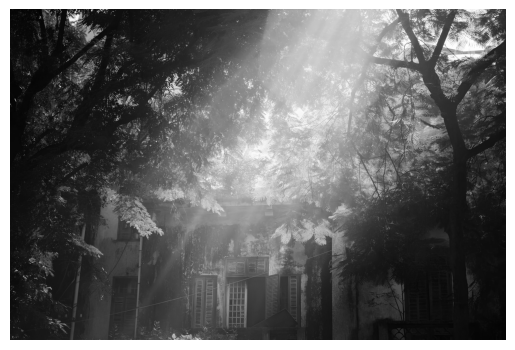

In [57]:
grayscale_img, _ = grayscale_gpu(IMAGE_FILE)

show_image(grayscale_img)

## Experiment different block size values

Do grayscale image by gpu, blockSize=32 ...
It took 0.033980369567871094 seconds to finish.
Do grayscale image by gpu, blockSize=64 ...
It took 0.036179304122924805 seconds to finish.
Do grayscale image by gpu, blockSize=128 ...
It took 0.035158395767211914 seconds to finish.
Do grayscale image by gpu, blockSize=192 ...
It took 0.03777265548706055 seconds to finish.
Do grayscale image by gpu, blockSize=256 ...
It took 0.03888201713562012 seconds to finish.
Do grayscale image by gpu, blockSize=384 ...
It took 0.0343170166015625 seconds to finish.
Do grayscale image by gpu, blockSize=512 ...
It took 0.03603529930114746 seconds to finish.
Do grayscale image by gpu, blockSize=768 ...
It took 0.0357365608215332 seconds to finish.
Do grayscale image by gpu, blockSize=1024 ...
It took 0.03732562065124512 seconds to finish.


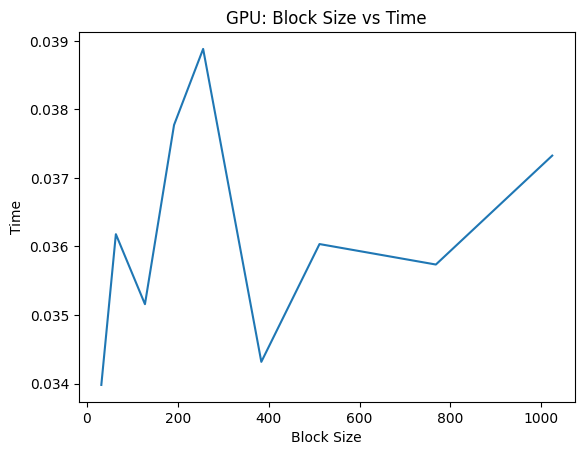

In [81]:
import matplotlib.pyplot as plt

block_sizes = [
    32, 64, 128, 192, 256, 384, 512, 768, 1024
]

process_times = []
img = None
for block_size in block_sizes:
  img, total_time = grayscale_gpu(IMAGE_FILE, block_size)
  process_times.append(total_time)

# show the latest image for testing
# show_image(img)

# Plot a graph of block size vs time
plt.plot(block_sizes, process_times)

plt.title('GPU: Block Size vs Time')
plt.xlabel('Block Size')
plt.ylabel('Time')

plt.show()